## Check Monte Carlo Simulation
Check if we can afford to reduce the number of simulations to 100,00 and still get reliable results, to speed up the creation of the dataset for ML models

In [1]:
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from utility_functions import get_df, get_standard_returns

In [11]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from dotenv import dotenv_values
from IPython.display import display
from MMAR.MMAR import MMAR
from tqdm.notebook import trange

warnings.filterwarnings("ignore")

### Load variables

In [4]:
start_date = "2005-01-01"
end_date = "2022-12-31"
df_path = "../data/raw/spy.csv"

In [5]:
config = dotenv_values("../config/.env")

In [6]:
# ALPHA_API = config["ALPHA_API"]

### Get files

In [7]:
spy = get_df(df_path, start_date, end_date)

In [8]:
spy = spy[spy.index < "31-12-2017"]

### Simulation using various sizes and steps

In [9]:
mmar = MMAR(spy["Close"], volume=spy["Volume"])

In [30]:
S0 = spy.Close.iloc[-1]
steps = [21, 252, 504]
num_simulations = [100_000, 250_000, 500_000, 1_000_000]

In [31]:
results = {}
for n in steps:
    print(f"Steps: {n}")
    results[n] = {}
    for num_sim in num_simulations:
        start = time.time()
        simulation = mmar.get_MMAR_MC(S0, n=n, num_sim=num_sim)
        stop = time.time()
        price = simulation[:, -1:].mean()
        std = simulation[:, -1:].std()
        exec_time = stop - start
        print(
            f"Using {num_sim:,.0f} simlations and {n} steps, the final price is {price:.2f} with std: {std:.2f}, in {exec_time:.2f} seconds."
        )
        results[n][num_sim] = {"Price": price, "Std": std, "Exec_Time": exec_time}
    print()

Steps: 21
Using 100,000 simlations and 21 steps, the final price is 267.10 with std: 11.61, in 0.27 seconds.
Using 250,000 simlations and 21 steps, the final price is 267.08 with std: 11.60, in 0.08 seconds.
Using 500,000 simlations and 21 steps, the final price is 267.13 with std: 11.60, in 0.29 seconds.
Using 1,000,000 simlations and 21 steps, the final price is 267.10 with std: 11.60, in 0.30 seconds.

Steps: 252
Using 100,000 simlations and 252 steps, the final price is 269.26 with std: 36.32, in 0.29 seconds.
Using 250,000 simlations and 252 steps, the final price is 269.28 with std: 36.54, in 0.89 seconds.
Using 500,000 simlations and 252 steps, the final price is 269.33 with std: 36.47, in 1.71 seconds.
Using 1,000,000 simlations and 252 steps, the final price is 269.31 with std: 36.45, in 3.39 seconds.

Steps: 504
Using 100,000 simlations and 504 steps, the final price is 272.70 with std: 58.71, in 0.65 seconds.
Using 250,000 simlations and 504 steps, the final price is 272.92 

In [49]:
for k in results.keys():
    print(f"Number of steps: {k}")
    display(
        pd.DataFrame.from_dict(results[k], orient="index")
        .assign(ci_high=lambda df: df.Price + df.Std / np.sqrt(df.index))
        .assign(ci_low=lambda df: df.Price - df.Std / np.sqrt(df.index))
        .round(decimals=2)
    )
    print()

Number of steps: 21


,Price,Std,Exec_Time,ci_high,ci_low
100000,267.10,11.61,0.27,267.13,267.06
250000,267.08,11.60,0.08,267.10,267.06
500000,267.13,11.60,0.29,267.14,267.11
1000000,267.10,11.60,0.30,267.11,267.09



Number of steps: 252


,Price,Std,Exec_Time,ci_high,ci_low
100000,269.26,36.32,0.29,269.38,269.15
250000,269.28,36.54,0.89,269.35,269.20
500000,269.33,36.47,1.71,269.38,269.28
1000000,269.31,36.45,3.39,269.35,269.27



Number of steps: 504


,Price,Std,Exec_Time,ci_high,ci_low
100000,272.70,58.71,0.65,272.88,272.51
250000,272.92,58.72,1.81,273.03,272.80
500000,273.02,58.66,3.71,273.11,272.94
1000000,273.05,58.63,8.14,273.11,272.99


Since we concentrate on the monthly time frame (21 days), we consider the error acceptable.

## Perform log return distribution for a simulation with 2,048 steps

In [10]:
selected_size = 2048
S0 = spy.Close.iloc[-selected_size]
simulation = mmar.get_MMAR_MC(S0, n=selected_size, num_sim=10_000)

In [20]:
selected_idx = np.random.choice(range(len(simulation)), size=1)
selected_sim = simulation[selected_idx, :].ravel()

In [21]:
normalized_returns = get_standard_returns((pd.Series(selected_sim)))

In [22]:
original_returns = get_standard_returns(spy["Close"])

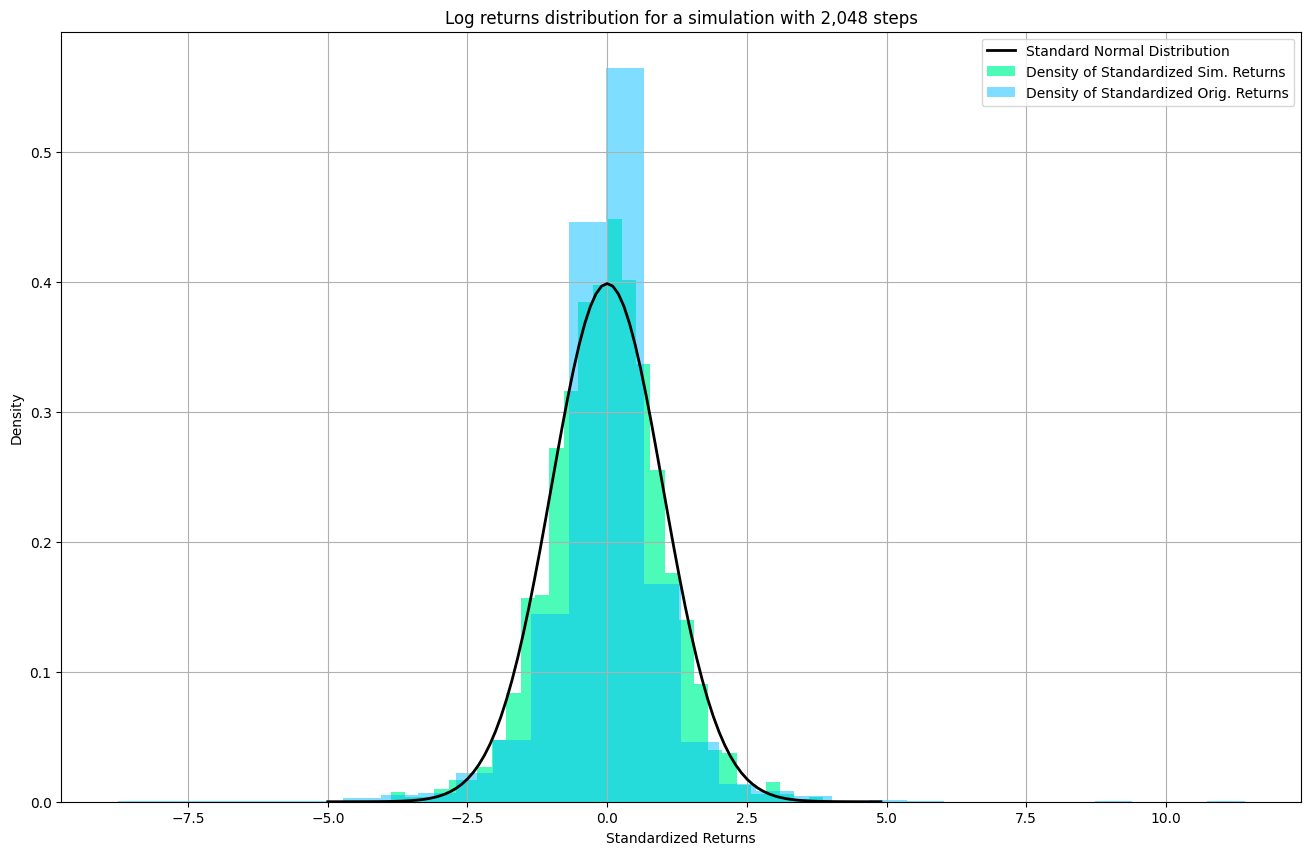

In [38]:
# Plot density and standard normal distribution
x = np.arange(-5, 5, 0.1)

plt.figure(figsize=(16, 10))
plt.plot(x, st.norm.pdf(x), "k-", lw=2, label="Standard Normal Distribution")
plt.hist(
    normalized_returns,
    density=True,
    alpha=0.7,
    color="mediumspringgreen",
    label="Density of Standardized Sim. Returns",
    bins=30,
)
plt.hist(
    original_returns,
    density=True,
    alpha=0.5,
    color="deepskyblue",
    label="Density of Standardized Orig. Returns",
    bins=30,
)
plt.grid(True)
plt.xlabel("Standardized Returns")
plt.ylabel("Density")
plt.title("Log returns distribution for a simulation with 2,048 steps")
plt.legend()
plt.show()

In [24]:
sample_normal = np.random.normal(size=selected_size)

In [37]:
print(
    f"Using {selected_size:,.0f} steps, the log returns for the simulated data follow a Normal distribution: {st.kstest(normalized_returns, sample_normal)[1] > 0.05}"
)

Using 2,048 steps, the log returns for the simulated data follow a Normal distribution: False


In [12]:
# Check Kurtosis and Skewness of simulated data


kurtosis_values = []
skew_values = []
for i in trange(len(simulation)):
    norm_val = get_standard_returns(simulation[i,])
    kurtosis_values.append(st.kurtosis(norm_val))
    skew_values.append(st.skew(norm_val))
kurtosis_values = pd.Series(kurtosis_values)
skew_values = pd.Series(skew_values)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
kurtosis_values.describe()

count    10000.000000
mean         0.920611
std          0.339303
min          0.113021
25%          0.692311
50%          0.867238
75%          1.089176
max          4.135019
dtype: float64

In [14]:
skew_values.describe()

count    10000.000000
mean        -0.002696
std          0.096850
min         -0.497040
25%         -0.066946
50%         -0.003204
75%          0.059949
max          0.419596
dtype: float64